In [2]:
import os

# Define base directories
base_dir = 'data/img_align_celeba'
train_dir = 'data/train'
val_dir = 'data/validation'
test_dir = 'data/test'

# Create directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [4]:
import pandas as pd
import shutil

# Load the partition data
partition_df = pd.read_csv('data/list_eval_partition.csv')
partition_df.columns = ['image_id', 'partition']  # Ensure the columns are correctly named

# Function to move images based on partition
def organize_images(partition_df, base_dir, train_dir, val_dir, test_dir):
    for index, row in partition_df.iterrows():
        file_path = os.path.join(base_dir, row['image_id'])
        if os.path.exists(file_path):  # Check if the file exists
            if row['partition'] == 0:
                shutil.move(file_path, os.path.join(train_dir, row['image_id']))
            elif row['partition'] == 1:
                shutil.move(file_path, os.path.join(val_dir, row['image_id']))
            elif row['partition'] == 2:
                shutil.move(file_path, os.path.join(test_dir, row['image_id']))
        else:
            print(f"File {row['image_id']} not found.")

# Call the function to organize images
organize_images(partition_df, base_dir, train_dir, val_dir, test_dir)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Define the ImageDataGenerator for validation and testing (without augmentation)
test_val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalization
)

# Setup generators
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
)

validation_generator = test_val_datagen.flow_from_directory(
    'data/validation',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
)

test_generator = test_val_datagen.flow_from_directory(
    'data/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
)


Found 162770 images belonging to 1 classes.
Found 19867 images belonging to 1 classes.
Found 19962 images belonging to 1 classes.


Image batch shape: (128, 128, 3)


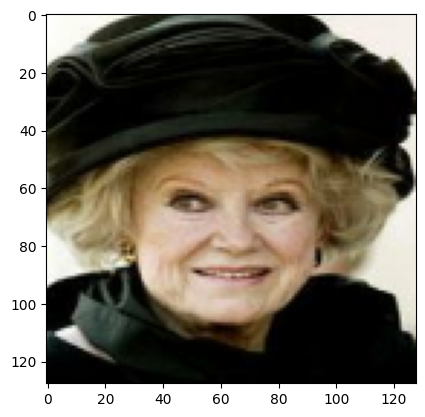

In [22]:
import tensorflow as tf
import os

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [128, 128])

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

# Set up a dataset of file paths
list_ds = tf.data.Dataset.list_files('data/test/*/*.jpg', shuffle=False)
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

for image in labeled_ds.take(1):
    print("Image batch shape:", image.shape)
    plt.imshow(image.numpy().astype("uint8"))
    plt.show()
